# Rolling Regression

Rolling OLS applies OLS across a fixed windows of observations and then rolls 
(moves or slides) the window across the data set. They key parameter is `window` 
which determines the number of observations used in each OLS regression. By 
default, `RollingOLS` drops missing values in the window and so will estimate 
the model using the available data points.

Estimated values are aligned so that models estimated using data points 
$i, i+1, ... i+window$ are stored in location $i+window$. 

Start by importing the modules that are used in this notebook.

In [1]:
import pandas_datareader as pdr
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
%matplotlib inline


`pandas-datareader` is used to download data from
[Ken French's website](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). 
The two data sets downloaded are the 3 Fama-French factors and the 10 industry portfolios. 
Data is available from 1926. 

The data are monthly returns for the factors or industry portfolios.

In [2]:
factors = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1926')[0]
print(factors.head())
industries = pdr.get_data_famafrench('10_Industry_Portfolios', start='1-1-1926')[0]
print(industries.head())

         Mkt-RF   SMB   HML    RF
Date                             
1926-07    2.96 -2.30 -2.87  0.22
1926-08    2.64 -1.40  4.19  0.25
1926-09    0.36 -1.32  0.01  0.23
1926-10   -3.24  0.04  0.51  0.32
1926-11    2.53 -0.20 -0.35  0.31


         NoDur  Durbl  Manuf  Enrgy  HiTec  Telcm  Shops  Hlth   Utils  Other
Date                                                                         
1926-07   1.45  15.55   4.69  -1.18   2.90   0.83   0.11   1.77   7.04   2.16
1926-08   3.97   3.68   2.81   3.47   2.66   2.17  -0.71   4.25  -1.69   4.38
1926-09   1.14   4.80   1.15  -3.39  -0.38   2.41   0.21   0.69   2.04   0.29
1926-10  -1.24  -8.23  -3.63  -0.78  -4.58  -0.11  -2.29  -0.57  -2.63  -2.85
1926-11   5.20  -0.19   4.10   0.01   4.71   1.63   6.43   5.42   3.71   2.11


The first model estimated is a rolling version of the CAPM that regresses
the excess return of Technology sector firms on the excess return of the market.

The window is 60 months, and so results are available after the first 60 (`window`) 
months. The first 59 (`window - 1`) estimates are all `nan` filled.

In [3]:
endog = industries.HiTec - factors.RF.values
exog = sm.add_constant(factors['Mkt-RF'])
rols = RollingOLS(endog, exog, window=60)
rres = rols.fit()
params = rres.params
print(params.head())
print(params.tail())

         const  Mkt-RF
Date                  
1926-07    NaN     NaN
1926-08    NaN     NaN
1926-09    NaN     NaN
1926-10    NaN     NaN
1926-11    NaN     NaN
            const    Mkt-RF
Date                       
2020-08  0.789891  1.049675
2020-09  0.723829  1.061682
2020-10  0.704460  1.056384
2020-11  0.687467  1.031385
2020-12  0.700236  1.027638


We next plot the market loading along with a 95% point-wise confidence interval.
The `alpha=False` omits the constant column, if present.  

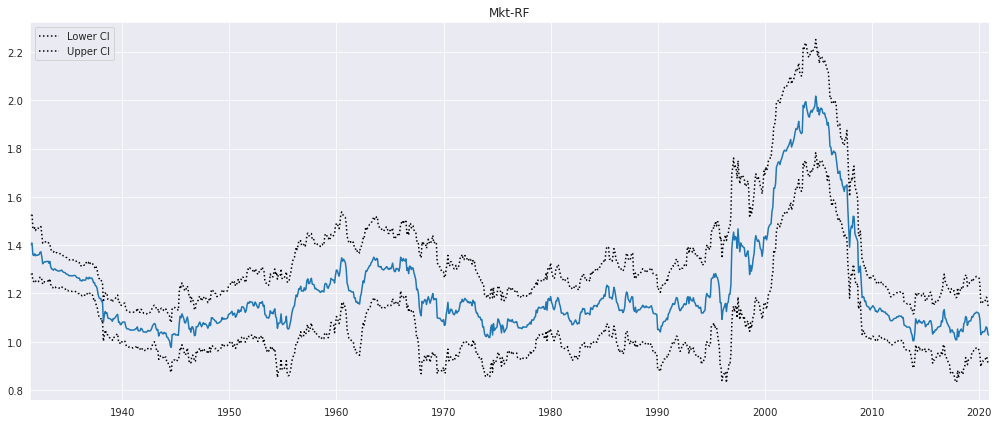

In [4]:
fig = rres.plot_recursive_coefficient(variables=['Mkt-RF'], figsize=(14,6))

Next, the model is expanded to include all three factors, the excess market, the size factor
and the value factor. 

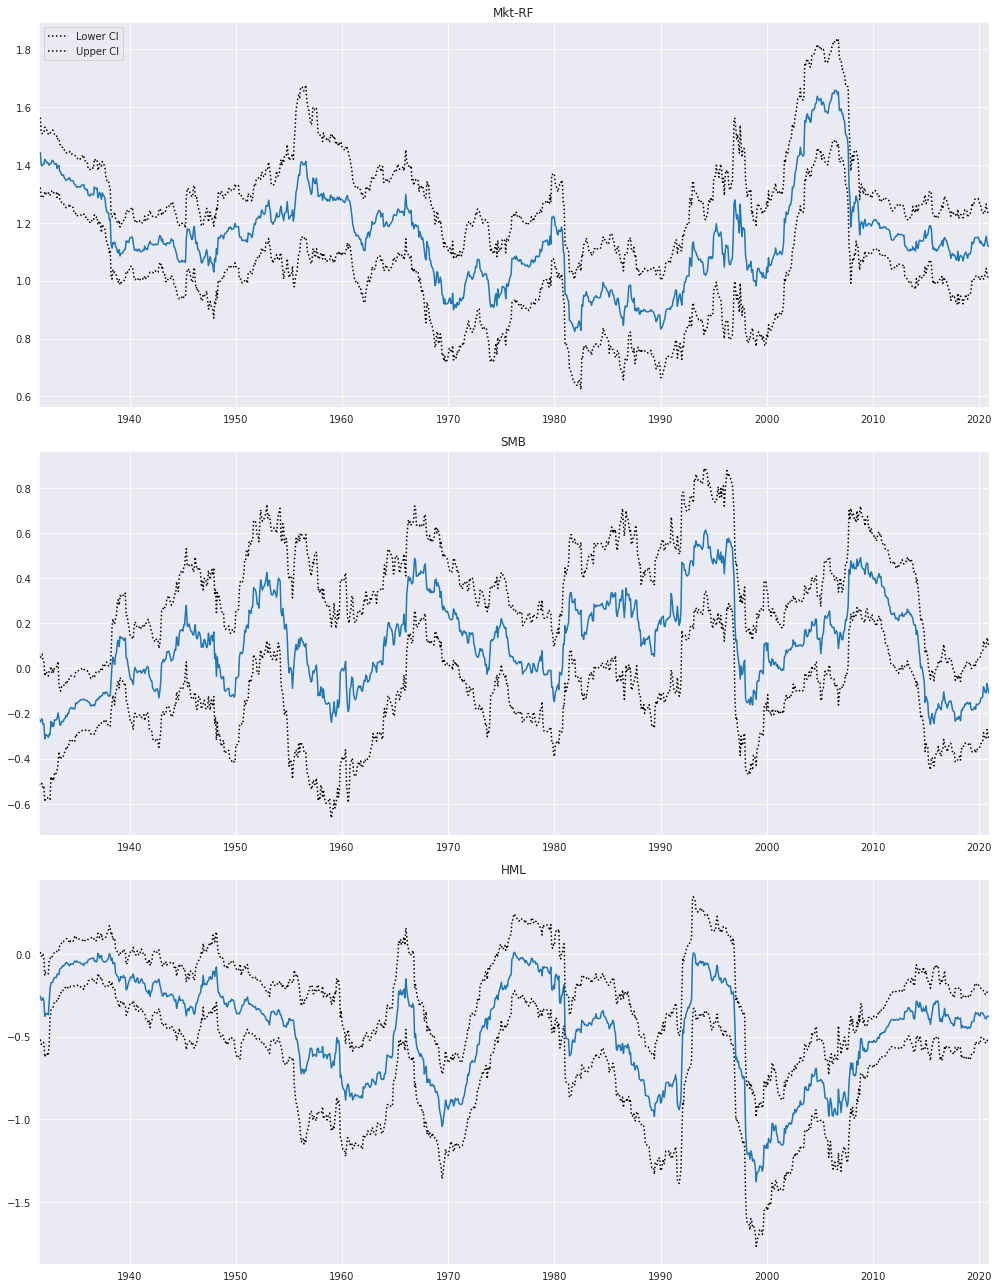

In [5]:
exog_vars = ['Mkt-RF', 'SMB', 'HML']
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(endog, exog, window=60)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=exog_vars, figsize=(14,18))

## Formulas

`RollingOLS` and `RollingWLS` both support model specification using the formula interface. The example below is equivalent to the 3-factor model estimated previously. Note that one variable is renamed to have a valid Python variable name.

In [6]:
joined = pd.concat([factors, industries], axis=1)
joined['Mkt_RF'] = joined['Mkt-RF']
mod = RollingOLS.from_formula('HiTec ~ Mkt_RF + SMB + HML', data=joined, window=60)
rres = mod.fit()
print(rres.params.tail())

         Intercept    Mkt_RF       SMB       HML
Date                                            
2020-08   0.430511  1.135973 -0.110281 -0.390980
2020-09   0.345706  1.151470 -0.111771 -0.392728
2020-10   0.408402  1.132134 -0.073487 -0.377088
2020-11   0.382264  1.117984 -0.097256 -0.377608
2020-12   0.404221  1.116581 -0.116456 -0.377026


## `RollingWLS`: Rolling Weighted Least Squares 

The `rolling` module also provides `RollingWLS` which takes an optional `weights` input to perform rolling weighted least squares.  It produces results that match `WLS` when applied to rolling windows of data. 

## Fit Options

Fit accepts other optional keywords to set the covariance estimator.  Only two estimators are supported, `'nonrobust'` (the classic OLS estimator) and `'HC0'` which is White's heteroskedasticity robust estimator.

You can set `params_only=True` to only estimate the model parameters.  This is substantially faster than computing the full set of values required to perform inference. 

Finally, the parameter `reset` can be set to a positive integer to control estimation error in very long samples. `RollingOLS` avoids the full matrix product when rolling by only adding the most recent observation and removing the dropped observation as it rolls through the sample. Setting `reset` uses the full inner product every `reset` periods.  In most applications this parameter can be omitted. 

In [7]:
%timeit rols.fit()
%timeit rols.fit(params_only=True)

320 ms ± 41.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


62.1 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
